# Model Training experiments


In [30]:
%load_ext autoreload
from data_functions import get_dataset
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler as SRS

STATE = "SP"
WEEKS = True
TRIANGLE = False
PAST_UNITS = 7
MAX_DELAY = 7
BATCH_SIZE = 16

dataset = get_dataset(weeks=WEEKS, triangle=TRIANGLE, past_units=PAST_UNITS, max_delay=MAX_DELAY, state=STATE)
## Define train and test indices
if WEEKS: # could also do random split, for now last indices as test
    train_idcs, test_idcs = range(300), range(300, dataset.__len__())
    TEST_BATCH_SIZE = dataset.__len__() - 300
else: 
    train_idcs, test_idcs = range(2500), range(2500, dataset.__len__())
    TEST_BATCH_SIZE = dataset.__len__() - 2500
train_sampler, test_sampler = SRS(train_idcs), SRS(test_idcs)
## Define train and test loader with SubsetRandomSampler over indices
#dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
## Maybe make batch_size of test s.t. only one batch, one evaluation?
train_loader, test_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler), DataLoader(dataset, batch_size=TEST_BATCH_SIZE, sampler=test_sampler)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/silaskoemen/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Imperial/Thesis/src/data_functions.py:81: DtypeWarning: Columns (7,11,23,45,46,47,55,65,69,75,86,102) have mixed types. Specify dtype option on import or set low_memory=False.
  dengdf = pd.read_csv(f"../data/derived/DENG{state}.csv", index_col=0)


In [132]:
import torch.nn as nn
import torch

## For matrix-like (two-dimensional) input data
class PNNTriangle(nn.Module):
    def __init__(self, past_units = 45, max_delay = 45):
        super().__init__()
        self.past_units = past_units
        self.max_delay = max_delay
        self.conv1 = nn.ConvTranspose1d(self.max_delay, 16, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose1d(16, 8, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.ConvTranspose1d(8, 1, kernel_size=4, stride=2, padding=1)
        self.fc1 = nn.Linear(self.past_units, self.past_units)
        self.fc2 = nn.Linear(self.past_units, self.past_units)
        self.fc3 = nn.Linear(320, 128)
        self.fc4 = nn.Linear(128, 1)

        self.bnorm1 = nn.BatchNorm1d(num_features=self.past_units)
        self.bnorm2 = nn.BatchNorm1d(num_features=16)
        self.bnorm3 = nn.BatchNorm1d(num_features=8)
        self.lnorm1 = nn.LayerNorm([self.max_delay])
        self.lnorm2 = nn.LayerNorm([self.max_delay])
        self.attn1 = nn.MultiheadAttention(embed_dim=self.past_units, num_heads=4, batch_first=True)
        self.attn2 = nn.MultiheadAttention(embed_dim=self.past_units, num_heads=4, batch_first=True)
        #self.attn2 = nn.MultiheadAttention()
        self.softplus = nn.Softplus()
        self.relu = nn.ReLU()
        self.silu = nn.SiLU()
    
    def forward(self, x):
        x = x.permute(0, 2, 1)
        #print(f"Coming in: {x.size()}")
        
        #print(f"After conv layers: {x.size()}")
        x_add = x.clone()
        x = self.lnorm1(x)
        x = self.attn1(x, x, x, need_weights = False)[0]
        x = self.fc1(x)
        x = self.silu(x)
        #x = torch.squeeze(x)
        x = x + x_add
        x_add = x.clone()
        #print(x.size())
        x = self.lnorm2(x)
        x = self.attn2(x, x, x, need_weights = False)[0]
        x = self.fc2(x)
        x = self.silu(x)
        x = x+x_add
        x = self.bnorm1(x)
        x = self.conv1(x)
        x = self.silu(x)
        x = self.bnorm2(x)
        x = self.conv2(x)
        x = self.silu(x)
        x = self.bnorm3(x)
        x = self.conv3(x)
        x = self.silu(x)
        x = torch.squeeze(x)
        #print(f"After conv {x.size()}")
        x = self.fc3(x)
        x = self.silu(x)
        x = self.fc4(x)
        x = torch.squeeze(x)
        #print(x.size())
        #x = torch.squeeze(x)
        pois = torch.distributions.Poisson(rate=self.softplus(x))
        #print(pois.size())
        return torch.distributions.Independent(pois, reinterpreted_batch_ndims=1)

## For summed (one-dimensional) input data
class PNNSum(nn.Module):
    def __init__(self, past_units = 45, max_delay = 45):
        super().__init__()
        self.past_units = past_units
        self.max_delay = max_delay
        self.fc1 = nn.Linear(self.past_units, self.past_units)
        self.fc2 = nn.Linear(self.past_units, self.past_units)
        self.fc3 = nn.Linear(7, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)
        self.fc6 = nn.Linear(64, 1)

        self.bnorm1, self.bnorm2, self.bnorm3, self.bnorm4 = nn.BatchNorm1d(num_features=1), nn.BatchNorm1d(num_features=1), nn.BatchNorm1d(num_features=1), nn.BatchNorm1d(num_features=1)
        self.lnorm1, self.lnorm2 = nn.LayerNorm([1]), nn.LayerNorm([1])
        self.attn1 = nn.MultiheadAttention(embed_dim=1, num_heads=1, batch_first=True)
        self.attn2 = nn.MultiheadAttention(embed_dim=1, num_heads=1, batch_first=True)
        self.drop1, self.drop2, self.drop3 = nn.Dropout(0.3), nn.Dropout(0.5), nn.Dropout(0.1)
        self.softplus = nn.Softplus()
        self.relu, self.silu = nn.ReLU(), nn.SiLU()
    
    def forward(self, x):
        x = torch.unsqueeze(x, -1)#.permute(0, 2, 1)
        #print(f"Before att layers: {x.size()}")
        x_add = x.clone()
        x = self.lnorm1(x)
        x = self.attn1(x, x, x, need_weights = False)[0]
        x = self.fc1(x.permute(0, 2, 1))
        x = self.silu(x).permute(0, 2, 1)
        #print(f"After 1st att: {x.size()}")
        x = x + x_add
        x_add = x.clone()
        x = self.lnorm2(x)
        x = self.attn2(x, x, x, need_weights = False)[0]
        x = self.fc2(x.permute(0, 2, 1))
        x = self.silu(x).permute(0, 2, 1)
        x = x+x_add
        x = x.permute(0, 2, 1) # [batch, past_units, 1] -> [batch, 1, past_units], so can take past_units
        x = self.silu(self.fc3(self.bnorm1(x)))
        x = self.drop1(x)
        x = self.silu(self.fc4(self.bnorm2(x)))
        x = self.drop2(x)
        x = self.silu(self.fc5(self.bnorm3(x)))
        x = self.drop3(x)
        x = self.fc6(self.bnorm4(x))
        x = torch.squeeze(x)
        #print(x.size())
        #x = torch.squeeze(x)
        pois = torch.distributions.Poisson(rate=1000*self.softplus(x))
        #print(pois.size())
        return torch.distributions.Independent(pois, reinterpreted_batch_ndims=1)


In [133]:
class EarlyStopper:
    """ Class implementing early stopping. Theoretically, PyTorch lightning could be used, but this might be more rubust.
    
    As seen e.g. in https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch and adapted to include 
    restoration of best weights.
    """
    def __init__(self, patience = 30):
        self.patience = patience
        self.counter = 0
        self.min_loss = float('inf')

    def early_stop(self, val_loss, model):
        if val_loss < self.min_loss:
            self.min_loss = val_loss
            self.counter = 0
            ## Save best weights
            torch.save(model.state_dict(), f"./weights/weights-{PAST_UNITS}-{MAX_DELAY}-{'week' if WEEKS else 'day'}-{('tri' if TRIANGLE else 'sum')}-{STATE}")
        elif val_loss > self.min_loss:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False
    
    def get_count(self):
        return self.counter

In [134]:
def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true.type(torch.int)) # re-cast to int after multiplication with 1000

def train(model, num_epochs, train_loader, test_loader, early_stopper, device = torch.device("mps")):
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

    for e in range(num_epochs):
        batch_loss = 0.
        model.train()
        for mat, y in train_loader:
            optimizer.zero_grad()
            dist_pred = model(mat)
            loss = nll(1000*y, dist_pred).mean()
            loss.backward()
            optimizer.step()
            batch_loss += loss.item()
        
        batch_loss /= len(train_loader)#(len(train_loader)*BATCH_SIZE) # mean already taken above

        with torch.no_grad(): # performance on test/validation set
            model.eval()
            test_batch_loss = 0.
            for mat, y in test_loader:
                test_loss = nll(1000*y, model(mat)).mean()
                test_batch_loss += test_loss.item()
            test_batch_loss /= len(test_loader)#(len(test_loader)*TEST_BATCH_SIZE)
            if early_stopper.early_stop(test_batch_loss, model):
                model.train() # set back to train for sampling
                break
        model.train()
        #if e % 50 == 0 or e == num_epochs-1:
        print(f"Epoch {e+1} - Train loss: {batch_loss:.3} - Test loss: {test_batch_loss:.3} - ES count: {early_stopper.get_count()}")

In [135]:
early_stopper = EarlyStopper(patience=75)
bll_nowcaster = PNNSum(past_units=PAST_UNITS, max_delay=MAX_DELAY)
train(bll_nowcaster, 150, train_loader, test_loader, early_stopper)
## Load best set of weights on test/validation set
bll_nowcaster.load_state_dict(torch.load(f"./weights/weights-{PAST_UNITS}-{MAX_DELAY}-{'week' if WEEKS else 'day'}-{('tri' if TRIANGLE else 'sum')}-{STATE}"))

Epoch 1 - Train loss: 6.01e+04 - Test loss: 3.82e+05 - ES count: 0
Epoch 2 - Train loss: 2.83e+04 - Test loss: 1.38e+05 - ES count: 0
Epoch 3 - Train loss: 2.4e+04 - Test loss: 5.47e+04 - ES count: 0
Epoch 4 - Train loss: 1.65e+04 - Test loss: 4.17e+04 - ES count: 0
Epoch 5 - Train loss: 1.84e+04 - Test loss: 3.99e+04 - ES count: 0
Epoch 6 - Train loss: 1.41e+04 - Test loss: 6.88e+04 - ES count: 1
Epoch 7 - Train loss: 1.2e+04 - Test loss: 1.92e+04 - ES count: 0
Epoch 8 - Train loss: 1.02e+04 - Test loss: 1.98e+04 - ES count: 1
Epoch 9 - Train loss: 1.09e+04 - Test loss: 1.38e+04 - ES count: 0
Epoch 10 - Train loss: 1.08e+04 - Test loss: 7.45e+03 - ES count: 0
Epoch 11 - Train loss: 7.97e+03 - Test loss: 1.19e+04 - ES count: 1
Epoch 12 - Train loss: 7.88e+03 - Test loss: 5.52e+03 - ES count: 0
Epoch 13 - Train loss: 6.34e+03 - Test loss: 1.06e+04 - ES count: 1
Epoch 14 - Train loss: 6.26e+03 - Test loss: 8.83e+03 - ES count: 2
Epoch 15 - Train loss: 6.58e+03 - Test loss: 9.44e+03 - ES 

<All keys matched successfully>

In [71]:
plotloader = DataLoader(dataset, batch_size=dataset.__len__(), shuffle=False)

In [168]:
%env PYTORCH_ENABLE_MPS_FALLBACK=1
from scipy.stats import poisson
import numpy as np
mat, y = next(iter(plotloader))
mat, y = mat.to("cpu"), y.to("cpu")
y_atm = mat[:, -1].numpy() # now wrong bc normalized
#preds = bll_nowcaster(mat).sample()
n_samples = 100
preds = np.zeros((y.shape[0], n_samples))
bll_nowcaster = bll_nowcaster.to("cpu")
for i in range(n_samples):
    preds[:, i] = bll_nowcaster(mat).sample().numpy()
preds_mean = np.mean(preds, axis=1) # bll_nowcaster(mat).mean.detach().numpy() # -> way worse
min_preds, max_preds = np.min(preds, axis=1), np.max(preds, axis=1)
lower_ci_95 = np.quantile(preds, 0.025, 1)
upper_ci_95 = np.quantile(preds, 0.975, 1)
lower_ci_50 = np.quantile(preds, 0.25, 1)
upper_ci_50 = np.quantile(preds, 0.75, 1)
lower_ci_95_TH = poisson.ppf(0.025, preds_mean)
upper_ci_95_TH = poisson.ppf(0.975, preds_mean)
lower_ci_50_TH = poisson.ppf(0.25, preds_mean)
upper_ci_50_TH = poisson.ppf(0.75, preds_mean)

env: PYTORCH_ENABLE_MPS_FALLBACK=1


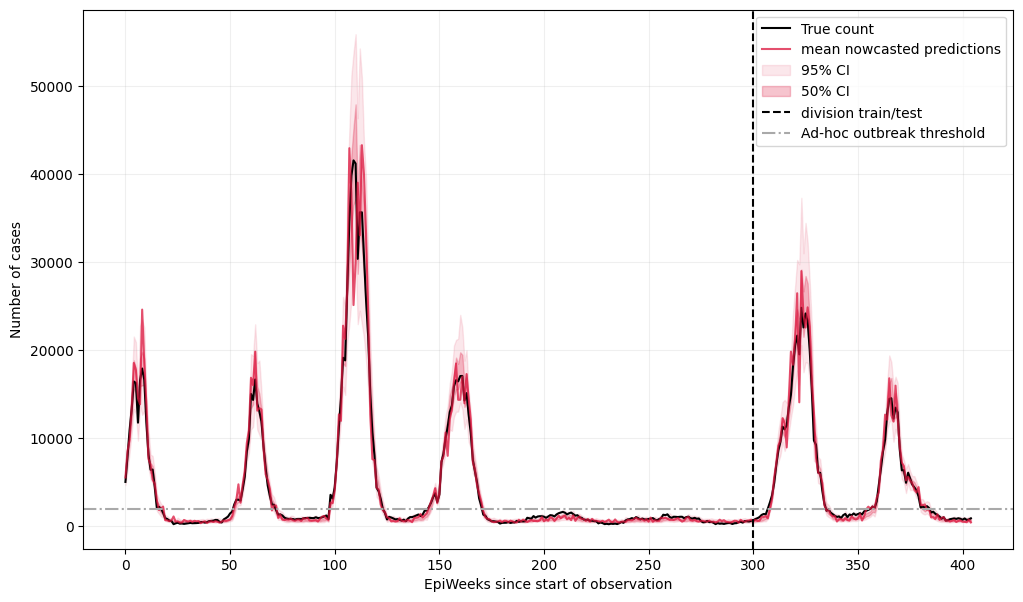

In [165]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 7))
plt.plot(1000*y, label="True count", c = "black")
#plt.plot(y_atm, label="reported on day", c = "darkgrey")
plt.plot(preds_mean, label = "mean nowcasted predictions", c = "crimson", alpha = 0.75)#, linestyle = "-.")
plt.fill_between(range(len(y_atm)),lower_ci_95, upper_ci_95, color = "crimson", alpha = 0.1, label = "95% CI")
plt.fill_between(range(len(y_atm)),lower_ci_50, upper_ci_50, color = "crimson", alpha = 0.25, label = "50% CI")
#plt.fill_between(range(len(y_atm)),lower_ci_95_TH, upper_ci_95_TH, color = "blue", alpha = 0.1, label = "95% CI TH")
#plt.fill_between(range(len(y_atm)),lower_ci_50_TH, upper_ci_50_TH, color = "blue", alpha = 0.25, label = "50% CI TH")
plt.grid(alpha=.2)
plt.axvline(300, color = "black", label="division train/test", linestyle="--")
plt.axhline(2000, color="darkgrey", label="Ad-hoc outbreak threshold", linestyle="-.")
plt.legend()
plt.ylabel("Number of cases")
plt.xlabel("EpiWeeks since start of observation")
#plt.xlim(200, 300)
#plt.ylim(0, 3000)
#plt.savefig("../outputs/figures/simple_forecast")
plt.show()

## Evaluation metrics
Given the mean of predictions and the actual values, can compute e.g. MSE, but most importantly WIS with confidence intervals to check how often contained. Moreover, should split in train and test set (e.g. 350 onwards) to see how performs on unseen data

In [166]:
mse_vals = []
count_95, count_50 = 0, 0
ypr = 1000*y
for i in range(len(ypr)):
    mse_vals.append((ypr[i] - preds_mean[i])**2)
    if ypr[i] > lower_ci_95[i] and ypr[i] < upper_ci_95[i]:
        count_95 += 1
    if ypr[i] > lower_ci_50[i] and ypr[i] < upper_ci_50[i]:
        count_50 += 1
print(f"fraction contained in 95%: {count_95/len(ypr)} | fraction contained in 50%: {count_50/len(ypr)}")

fraction contained in 95%: 0.891358024691358 | fraction contained in 50%: 0.42962962962962964


In [184]:
%reload_ext autoreload
%autoreload 2
from metrics import CWC, PICPS
PICPS([0.95, 0.5], {0.95: (lower_ci_95, upper_ci_95), 0.5: (lower_ci_50, upper_ci_50)}, preds_mean)
CWC([0.95, 0.5], {0.95: (min_preds, max_preds), 0.5: (lower_ci_50, upper_ci_50)}, {0.95: (lower_ci_95, upper_ci_95), 0.5: (lower_ci_50, upper_ci_50)}, preds_mean)

0.8664067947977365

## Forecasting/outbreak warning
Given that always single value predicted, can update current data and form next prediction and thus forecast days/weeks into the future. Moreover, try to find "peak" of outbreak and maybe assess likelihood of outbreak.

Apart from that, variance should go up on each step, so could e.g. sample current prediction and then continue with empirical bounds, BUT if continue to sample at each future step grows exponentially

Seems like once crosses 2-3k cases, outbreak occurs, so could sample from forecast and then return proportion higher than 2-3k as probability of outbreak occuring within forecast horizon. Alternatively, could look at change in cases over previous mean and if exceeds boundary classify as outbreak

EWMA, tune parameters to not include small fluctuations

## Peak prediction

Useful to be able to predict when peak of cases is reached, so resources can be planned/distributed. Could theoretically draw many times and just continue with random draw and then plot all curves, along with distribution of peak values.

In [176]:
for j in range(25):
    print(f"Int j={j}, j//5 = {j//5}, j%5 = {j%5}, j%5 > (md=)4-j//5 {bool(j%5 > 4-j//5)}")

Int j=0, j//5 = 0, j%5 = 0, j%5 > (md=)4-j//5 False
Int j=1, j//5 = 0, j%5 = 1, j%5 > (md=)4-j//5 False
Int j=2, j//5 = 0, j%5 = 2, j%5 > (md=)4-j//5 False
Int j=3, j//5 = 0, j%5 = 3, j%5 > (md=)4-j//5 False
Int j=4, j//5 = 0, j%5 = 4, j%5 > (md=)4-j//5 False
Int j=5, j//5 = 1, j%5 = 0, j%5 > (md=)4-j//5 False
Int j=6, j//5 = 1, j%5 = 1, j%5 > (md=)4-j//5 False
Int j=7, j//5 = 1, j%5 = 2, j%5 > (md=)4-j//5 False
Int j=8, j//5 = 1, j%5 = 3, j%5 > (md=)4-j//5 False
Int j=9, j//5 = 1, j%5 = 4, j%5 > (md=)4-j//5 True
Int j=10, j//5 = 2, j%5 = 0, j%5 > (md=)4-j//5 False
Int j=11, j//5 = 2, j%5 = 1, j%5 > (md=)4-j//5 False
Int j=12, j//5 = 2, j%5 = 2, j%5 > (md=)4-j//5 False
Int j=13, j//5 = 2, j%5 = 3, j%5 > (md=)4-j//5 True
Int j=14, j//5 = 2, j%5 = 4, j%5 > (md=)4-j//5 True
Int j=15, j//5 = 3, j%5 = 0, j%5 > (md=)4-j//5 False
Int j=16, j//5 = 3, j%5 = 1, j%5 > (md=)4-j//5 False
Int j=17, j//5 = 3, j%5 = 2, j%5 > (md=)4-j//5 True
Int j=18, j//5 = 3, j%5 = 3, j%5 > (md=)4-j//5 True
Int j=19